In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Reference for dataset


@inproceedings{feather,
               title={{Characteristic Functions on Graphs: Birds of a Feather, from Statistical Descriptors to Parametric Models}},
               author={Benedek Rozemberczki and Rik Sarkar},
               year={2020},
	       pages = {1325–1334},
	       booktitle={Proceedings of the 29th ACM International Conference on Information and Knowledge Management (CIKM '20)},
	       organization={ACM},
}

### load facebook dataset

In [2]:
import pandas as pd
edges =pd.read_csv('/content/gdrive/MyDrive/ML/project/lasftm_asia/lasftm_asia/lastfm_asia_edges.csv')

targets = pd.read_csv('/content/gdrive/MyDrive/ML/project/lasftm_asia/lasftm_asia/lastfm_asia_target.csv')

In [3]:
targets.head()

,id,target
0,0,8
1,1,17
2,2,3
3,3,17
4,4,5


In [4]:
edges.head()

,node_1,node_2
0,0,747
1,1,4257
2,1,2194
3,1,580
4,1,6478


In [5]:
len(targets.target.unique())

18

## visualization of data

In [6]:
import networkx as network
network_graph = network.convert_matrix.from_pandas_edgelist(edges,"node_1","node_2")
total_nodes=network.number_of_nodes(network_graph)
total_edges=network.number_of_edges(network_graph)
print("total nodes=",total_nodes," total edges=",total_edges)

total nodes= 7624  total edges= 27806


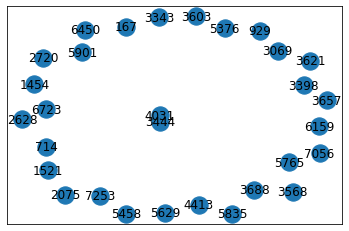

In [7]:
import random as r
random_nodes = r.sample(network_graph.nodes, 30)
subgraph=network_graph.subgraph(random_nodes)
p=network.spring_layout(subgraph, seed=0)
network.draw_networkx(subgraph, pos=p,cmap='coolwarm')

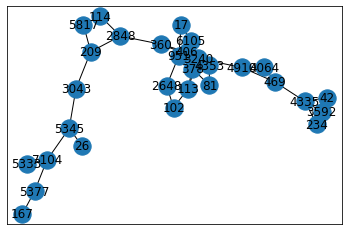

In [8]:
dfs_from_42 = list(network.dfs_preorder_nodes(network_graph, 42))
dfs_from_42=dfs_from_42[:30]
subgraph=network_graph.subgraph(dfs_from_42)
p=network.spring_layout(subgraph, seed=0)
network.draw_networkx(subgraph, pos=p,cmap='coolwarm')

In [3]:
!pip install karateclub

     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 1.8MB 5.0MB/s 
     |████████████████████████████████| 23.9MB 125kB/s 
  Created wheel for karateclub: filename=karateclub-1.1.0-cp37-none-any.whl size=94243 sha256=6302054dbb99cf200e0505b9b73e708d2a5fd4a16c91f386a3abc428bf950885
  Stored in directory: /root/.cache/pip/wheels/e4/7f/b9/cb6bd89572be748b7ba620970fbd5e19d5729e01b07bc05686
Successfully built karateclub
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## random walk

In [63]:
from karateclub.utils.walker import RandomWalker
walk_len=30
walk_num=10
random_walk = RandomWalker(walk_len,walk_num)
random_walk.do_walks(network_graph)

In [64]:
print("No of walks generated =",len(random_walk.walks))

No of walks generated = 76240


In [65]:
X=random_walk.walks

In [66]:
from gensim.models.word2vec import Word2Vec
learn_rate=0.001
latent_dimension=100
window_size=5

In [67]:
WordtoVec=Word2Vec(X,hs=1,sg=1,alpha=learn_rate,vector_size=latent_dimension,window=window_size,min_count=1,workers=4,seed=0)        
      

In [68]:
node_repre=[]
for i in range(len(targets.target)):
  node_repre.append(WordtoVec.wv.__getitem__(str(i)))

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(node_repre, targets.target, test_size=0.2)
classifier= DecisionTreeClassifier(random_state=0)
classifier.fit(X_train,y_train)
y_pred= classifier.predict(X_test) 

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7337704918032787

In [71]:
from tqdm import tqdm
import numpy as np


In [72]:
accuracy_random=[]
for split in tqdm(np.arange(0.05, 1, 0.05)):
  X_train, X_test, y_train, y_test = train_test_split(node_repre, targets.target,train_size=split,random_state=0)
  classifier= DecisionTreeClassifier(random_state=0)
  classifier.fit(X_train,y_train)
  y_pred= classifier.predict(X_test) 
  accuracy_random.append(accuracy_score(y_test, y_pred))

100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


### change of walk length

In [4]:
from karateclub.utils.walker import RandomWalker
accuracy_walklen=[]
walk_length_list=[10,20,30,40,50,60,70]

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [116]:
from gensim.models.word2vec import Word2Vec
learn_rate=0.001
latent_dimension=100
window_size=5

In [117]:
for l in range(len(walk_length_list)):
  walk_num=10
  random_walk = RandomWalker(walk_length_list[l],walk_num)
  random_walk.do_walks(network_graph)
  X=random_walk.walks
  WordtoVec=Word2Vec(X,hs=1,sg=1,alpha=learn_rate,vector_size=latent_dimension,window=window_size,min_count=1,workers=4,seed=0)   
  node_repre=[]
  for i in range(len(targets.target)):
    node_repre.append(WordtoVec.wv.__getitem__(str(i)))
  X_train, X_test, y_train, y_test = train_test_split(node_repre, targets.target, test_size=0.2)
  classifier= DecisionTreeClassifier(random_state=0)
  classifier.fit(X_train,y_train)
  y_pred= classifier.predict(X_test) 
  accuracy_walklen.append(accuracy_score(y_test, y_pred))
  print("walk length=",walk_length_list[l] ,"accuracy=",accuracy_score(y_test, y_pred))  


walk length= 10 accuracy= 0.41704918032786886
walk length= 20 accuracy= 0.6990163934426229
walk length= 30 accuracy= 0.7245901639344262
walk length= 40 accuracy= 0.7121311475409836
walk length= 50 accuracy= 0.7259016393442623
walk length= 60 accuracy= 0.7475409836065574
walk length= 70 accuracy= 0.7219672131147541


In [6]:
import numpy as np
walk_length_list=np.array(walk_length_list)
accuracy_walklen=np.array(accuracy_walklen)

[]

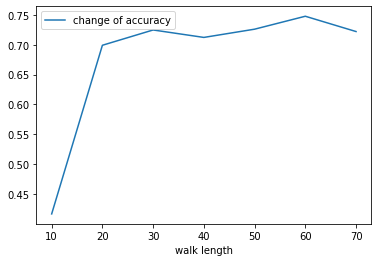

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=walk_length_list, y =accuracy_walklen, label='change of accuracy')
plt.xlabel('walk length')
plt.plot()

## Baised Random walk

In [34]:
from karateclub.utils.walker import BiasedRandomWalker
walk_len=40
walk_num=10
p=0.5
q=0.25

In [35]:
Baised_random_walk = BiasedRandomWalker(walk_len,walk_num,p,q)
Baised_random_walk.do_walks(network_graph)

In [36]:
print("No of walks generated =",len(Baised_random_walk.walks))

No of walks generated = 76240


In [37]:
baised_X=X=Baised_random_walk.walks

In [38]:
B_WordtoVec=Word2Vec(baised_X,hs=1,sg=1,alpha=learn_rate,vector_size=latent_dimension,window=window_size,min_count=1,workers=4,seed=0)        

In [39]:
baised_node_repre=[]
for i in range(len(targets.target)):
  baised_node_repre.append(WordtoVec.wv.__getitem__(str(i)))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(baised_node_repre, targets.target, test_size=0.2)
classifier= DecisionTreeClassifier(random_state=0)
classifier.fit(X_train,y_train)
y_pred= classifier.predict(X_test) 

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7180327868852459

### Grid Search on  return and Inout parameters

In [51]:
p=[0.5,0.6,0.7]
q=[0.15,0.2,0.25,]

In [52]:
walk_len=40
walk_num=10
accuracy_baised=[]
for i in range(len(p)):
  for j in range(len(q)):
    Baised_random_walk = BiasedRandomWalker(walk_len,walk_num,p[i],q[j])
    Baised_random_walk.do_walks(network_graph)    
    baised_X=X=Baised_random_walk.walks
    B_WordtoVec=Word2Vec(baised_X,hs=1,sg=1,alpha=learn_rate,vector_size=latent_dimension,window=window_size,min_count=1,workers=4,seed=0)       
    baised_node_repre=[]
    for x in range(len(targets.target)):
      baised_node_repre.append(B_WordtoVec.wv.__getitem__(str(x))) 
    X_train, X_test, y_train, y_test = train_test_split(baised_node_repre, targets.target, test_size=0.2,random_state=0)
    classifier= DecisionTreeClassifier(random_state=0)
    classifier.fit(X_train,y_train)
    y_pred= classifier.predict(X_test)
    accuracy_baised.append(accuracy_score(y_test, y_pred))
    print("p=",p[i]," q=",q[j]," accuracy=",accuracy_score(y_test, y_pred))
    





p= 0.5  q= 0.15  accuracy= 0.7390163934426229
p= 0.5  q= 0.2  accuracy= 0.7344262295081967
p= 0.5  q= 0.25  accuracy= 0.7298360655737705
p= 0.6  q= 0.15  accuracy= 0.7232786885245902
p= 0.6  q= 0.2  accuracy= 0.7344262295081967
p= 0.6  q= 0.25  accuracy= 0.7383606557377049
p= 0.7  q= 0.15  accuracy= 0.7350819672131148
p= 0.7  q= 0.2  accuracy= 0.7324590163934426
p= 0.7  q= 0.25  accuracy= 0.7291803278688525


### best model of grid search

In [104]:
pp=0.5
qp=0.15

In [105]:
Baised_random_walk = BiasedRandomWalker(walk_len,walk_num,pp,qp)
Baised_random_walk.do_walks(network_graph)

In [106]:
print("No of walks generated =",len(Baised_random_walk.walks))

No of walks generated = 76240


In [107]:
baised_X=X=Baised_random_walk.walks

In [108]:
B_WordtoVec=Word2Vec(baised_X,hs=1,sg=1,alpha=learn_rate,vector_size=latent_dimension,window=window_size,min_count=1,workers=4,seed=0)        

In [109]:
baised_node_repre=[]
for i in range(len(targets.target)):
  baised_node_repre.append(B_WordtoVec.wv.__getitem__(str(i)))

In [110]:
X_train, X_test, y_train, y_test = train_test_split(baised_node_repre, targets.target, test_size=0.2)
classifier= DecisionTreeClassifier(random_state=0)
classifier.fit(X_train,y_train)
y_pred= classifier.predict(X_test) 

In [111]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.740983606557377

In [112]:
accuracy_baisedrandom=[]
for split in tqdm(np.arange(0.05, 1, 0.05)):
  X_train, X_test, y_train, y_test = train_test_split(baised_node_repre, targets.target,train_size=split,random_state=0)
  classifier= DecisionTreeClassifier(random_state=0)
  classifier.fit(X_train,y_train)
  y_pred= classifier.predict(X_test) 
  accuracy_baisedrandom.append(accuracy_score(y_test, y_pred))

100%|██████████| 19/19 [00:16<00:00,  1.15it/s]


## Comparing Baised and random

[]

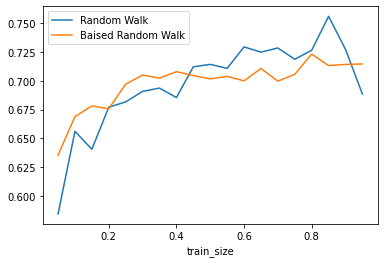

In [114]:
sns.lineplot(x = np.arange(0.05 ,1, 0.05), y = accuracy_random,label='Random Walk')
sns.lineplot(x = np.arange(0.05, 1, 0.05), y = accuracy_baisedrandom,label='Baised Random Walk')
plt.xlabel('train_size')
plt.plot()